# Data Cleaning and Exploratory Data Analysis - Peru Audio Transcripts
### **Cleaning Transcription Data and Comprehensive EDA**

This notebook performs comprehensive data cleaning and exploratory data analysis on the Peru audio transcript dataset. The transcription process had some issues that need to be addressed before analysis.

---

**Key Cleaning Tasks:**

| Task | Description |
|------|---------|
| Word Count Recovery | Recalculate word counts from transcript text (currently all 0) |
| Duration Estimation | Calculate approximate recording duration from word count |
| Data Quality | Remove rows with missing transcriptions |
| Speaker Count Fix | Extract speaker counts from JSON using regex |
| Column Cleanup | Remove unnecessary 'First Speaker' columns |
| Pairing Logic | Remove rows without matching clip pairs |

**EDA Focus Areas:**
- Transcript length distribution and outliers
- Data quality assessment
- Content analysis
- Statistical summaries


In [1]:
!pip install -q plotly wordcloud textstat

In [2]:
# --- Setup and Dependencies ------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import warnings
from pathlib import Path
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy import stats
from collections import Counter
import importlib.util

# Check if we're in Colab
IN_COLAB = importlib.util.find_spec('google.colab') is not None

if IN_COLAB:
    # Install additional packages if needed
    import subprocess
    subprocess.run(['pip', 'install', 'plotly', 'wordcloud', 'textstat'], check=True, capture_output=True)
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = Path('/content/drive/My Drive/world bank/data/Peru')
else:
    ROOT = Path('/Users/mkrasnow/Desktop/montesa')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Setup complete")
print(f"📁 Working directory: {ROOT}")


✅ Setup complete
📁 Working directory: /Users/mkrasnow/Desktop/montesa


In [3]:
# --- File Paths and Configuration ------------------------------------------
INPUT_CSV = ROOT / 'new/formattedData/peru_with_transcripts.csv'
CLEANED_CSV = ROOT / 'new/formattedData/peru_cleaned_transcripts.csv'
ANALYSIS_DIR = ROOT / 'new/analysis'
FIGURES_DIR = ANALYSIS_DIR / 'figures'

# Create analysis directories
for directory in [ANALYSIS_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Configuration
WORDS_PER_MINUTE = 150  # Average speaking rate for duration estimation
MIN_TRANSCRIPT_WORDS = 10  # Minimum words for a valid transcript
OUTLIER_THRESHOLD = 3  # Standard deviations for outlier detection

print(f"📄 Input file: {INPUT_CSV}")
print(f"💾 Output file: {CLEANED_CSV}")
print(f"📊 Analysis directory: {ANALYSIS_DIR}")


📄 Input file: /Users/mkrasnow/Desktop/montesa/new/formattedData/peru_with_transcripts.csv
💾 Output file: /Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv
📊 Analysis directory: /Users/mkrasnow/Desktop/montesa/new/analysis


In [4]:
# --- Load and Initial Data Inspection --------------------------------------
print("📖 Loading data...")
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"✅ Loaded {len(df)} rows and {len(df.columns)} columns")
except FileNotFoundError:
    print(f"❌ File not found: {INPUT_CSV}")
    print("Please ensure the transcription notebook has been run and the file exists.")
    raise

# Display basic info
print(f"\n📋 Dataset Shape: {df.shape}")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Show column names for reference
print(f"\n📊 Column count by category:")
transcript_cols = [col for col in df.columns if 'Transcript' in col]
evaluation_cols = [col for col in df.columns if any(x in col for x in ['1.', '2.', '3.', '4.', '5.', '6.', '7.', '8.', '9.'])]
metadata_cols = [col for col in df.columns if col not in transcript_cols and col not in evaluation_cols]

print(f"  - Transcript columns: {len(transcript_cols)}")
print(f"  - Evaluation columns: {len(evaluation_cols)}")
print(f"  - Metadata columns: {len(metadata_cols)}")

# Show transcript-related columns
print(f"\n🗣️ Transcript-related columns:")
for col in sorted(transcript_cols):
    print(f"  - {col}")


📖 Loading data...
✅ Loaded 227 rows and 77 columns

📋 Dataset Shape: (227, 77)
💾 Memory usage: 92.9 MB

📊 Column count by category:
  - Transcript columns: 22
  - Evaluation columns: 37
  - Metadata columns: 18

🗣️ Transcript-related columns:
  - First Audio Transcript
  - First Audio Transcript Duration Seconds
  - First Audio Transcript First Speaker
  - First Audio Transcript Has Audio Events
  - First Audio Transcript Language Code
  - First Audio Transcript Language Probability
  - First Audio Transcript Speaker Count
  - First Audio Transcript Text
  - First Audio Transcript Word Count
  - First Audio Transcript_JSON
  - Last Audio Transcript
  - Last Audio Transcript Duration Seconds
  - Last Audio Transcript First Speaker
  - Last Audio Transcript Has Audio Events
  - Last Audio Transcript Language Code
  - Last Audio Transcript Language Probability
  - Last Audio Transcript Speaker Count
  - Last Audio Transcript Text
  - Last Audio Transcript Word Count
  - Last Audio Transcr

In [5]:
# --- Handle Pairing of Rows ------------------------------------------------
print("🔗 Handling pairing of rows based on School_Clip identifiers...")

# Extract base identifier (6-7 digit) from School_Clip
df['base_id'] = df['School_Clip'].astype(str).str.extract(r'(\d{6,7})')[0]

# Count occurrences of each identifier
id_counts = df['base_id'].value_counts()

# Identify identifiers that do not have exactly two rows (unpaired)
unpaired_ids = id_counts[id_counts != 2].index.tolist()
print(f"  ⚠️ Found {len(unpaired_ids)} unpaired identifiers")

# Record unpaired identifiers for analysis JSON
removed_unpaired_ids = unpaired_ids.copy()

# Remove rows corresponding to unpaired identifiers
initial_pairing_count = len(df)
df = df[~df['base_id'].isin(unpaired_ids)].copy()
after_pairing_count = len(df)
removed_pairing_count = initial_pairing_count - after_pairing_count

print(f"  🗑️ Removed {removed_pairing_count} rows without pairs ({removed_pairing_count/initial_pairing_count*100:.1f}%)")


🔗 Handling pairing of rows based on School_Clip identifiers...
  ⚠️ Found 19 unpaired identifiers
  🗑️ Removed 19 rows without pairs (8.4%)


## 🧹 Data Cleaning

We'll systematically clean the data to fix issues from the transcription process:

1. **Handle Pairing**: Remove rows without matching clip pairs
2. **Fix Word Counts**: Recalculate from transcript text
3. **Calculate Durations**: Estimate recording length from word count
4. **Fix Speaker Counts**: Extract from JSON using regex
5. **Remove Incomplete Rows**: Filter out rows missing transcriptions
6. **Column Cleanup**: Remove unnecessary columns


In [6]:
# --- Data Cleaning Functions -----------------------------------------------

def count_words_in_text(text):
    """Count words in a text string, handling NaN and empty values."""
    if pd.isna(text) or text == '' or str(text).strip() == '':
        return 0
    # Simple word count by splitting on whitespace
    words = str(text).strip().split()
    # Filter out very short "words" that might be artifacts
    meaningful_words = [w for w in words if len(w) >= 2]
    return len(meaningful_words)

def estimate_duration_from_words(word_count, words_per_minute=WORDS_PER_MINUTE):
    """Estimate audio duration in seconds from word count."""
    if word_count <= 0:
        return 0
    return (word_count / words_per_minute) * 60

def extract_speaker_count_from_json(json_text):
    """Extract speaker count from transcript JSON using regex."""
    if pd.isna(json_text) or json_text == '' or str(json_text).strip() == '':
        return 0
    
    try:
        # Try to parse as JSON first
        json_data = json.loads(str(json_text))
        json_string = json.dumps(json_data)
    except (json.JSONDecodeError, TypeError):
        # If parsing fails, use the raw string
        json_string = str(json_text)
    
    # Use regex to find speaker patterns like 'speaker_1', 'speaker_2', etc.
    speaker_pattern = r'"?speaker_?(\d+)"?'
    speakers = re.findall(speaker_pattern, json_string, re.IGNORECASE)
    
    if speakers:
        # Count unique speakers
        unique_speakers = set(speakers)
        return len(unique_speakers)
    
    return 0

def has_valid_transcript(text_col, json_col):
    """Check if a row has a valid transcript in either text or JSON column."""
    # Check text column
    if not pd.isna(text_col) and str(text_col).strip() != '':
        if len(str(text_col).strip()) > MIN_TRANSCRIPT_WORDS:
            return True
    
    # Check JSON column
    if not pd.isna(json_col) and str(json_col).strip() != '':
        try:
            json_data = json.loads(str(json_col))
            if 'text' in json_data and json_data['text']:
                if len(str(json_data['text']).strip()) > MIN_TRANSCRIPT_WORDS:
                    return True
        except (json.JSONDecodeError, TypeError):
            pass
    
    return False

print("✅ Cleaning functions defined")


✅ Cleaning functions defined


In [7]:
# --- Fix Word Counts -------------------------------------------------------
print("🔢 Fixing word counts...")

# Create a copy for cleaning (post-pairing)
df_clean = df.copy()

# Fix word counts for both transcript types
transcript_types = ['First Audio Transcript', 'Last Audio Transcript']

for transcript_type in transcript_types:
    text_col = f'{transcript_type} Text'
    word_count_col = f'{transcript_type} Word Count'
    
    if text_col in df_clean.columns:
        print(f"  📝 Processing {transcript_type}...")
        
        # Calculate word counts
        df_clean[word_count_col] = df_clean[text_col].apply(count_words_in_text)
        
        # Show statistics
        valid_counts = df_clean[df_clean[word_count_col] > 0][word_count_col]
        if len(valid_counts) > 0:
            print(f"    ✅ Updated {len(valid_counts)} rows")
            print(f"    📊 Word count stats: min={valid_counts.min()}, max={valid_counts.max()}, mean={valid_counts.mean():.1f}")
        else:
            print(f"    ⚠️ No valid transcripts found")
    else:
        print(f"  ❌ Column {text_col} not found")

print("\n✅ Word count fixing complete")


🔢 Fixing word counts...
  📝 Processing First Audio Transcript...
    ✅ Updated 200 rows
    📊 Word count stats: min=20, max=3380, mean=1230.1
  📝 Processing Last Audio Transcript...
    ✅ Updated 199 rows
    📊 Word count stats: min=3, max=4089, mean=739.8

✅ Word count fixing complete


In [8]:
# --- Calculate Estimated Durations -----------------------------------------
print("⏱️ Calculating estimated durations...")

for transcript_type in transcript_types:
    word_count_col = f'{transcript_type} Word Count'
    duration_col = f'{transcript_type} Estimated Duration Seconds'
    
    if word_count_col in df_clean.columns:
        print(f"  ⏲️ Processing {transcript_type}...")
        
        # Calculate estimated durations
        df_clean[duration_col] = df_clean[word_count_col].apply(
            lambda x: estimate_duration_from_words(x, WORDS_PER_MINUTE)
        )
        
        # Show statistics
        valid_durations = df_clean[df_clean[duration_col] > 0][duration_col]
        if len(valid_durations) > 0:
            print(f"    ✅ Calculated durations for {len(valid_durations)} rows")
            print(f"    📊 Duration stats: min={valid_durations.min():.1f}s, max={valid_durations.max():.1f}s, mean={valid_durations.mean():.1f}s")
            print(f"    📊 Duration range: {valid_durations.min()/60:.1f}-{valid_durations.max()/60:.1f} minutes")
        else:
            print(f"    ⚠️ No valid durations calculated")

print(f"\n💡 Note: Duration estimates based on {WORDS_PER_MINUTE} words per minute")
print("✅ Duration calculation complete")


⏱️ Calculating estimated durations...
  ⏲️ Processing First Audio Transcript...
    ✅ Calculated durations for 200 rows
    📊 Duration stats: min=8.0s, max=1352.0s, mean=492.0s
    📊 Duration range: 0.1-22.5 minutes
  ⏲️ Processing Last Audio Transcript...
    ✅ Calculated durations for 199 rows
    📊 Duration stats: min=1.2s, max=1635.6s, mean=295.9s
    📊 Duration range: 0.0-27.3 minutes

💡 Note: Duration estimates based on 150 words per minute
✅ Duration calculation complete


In [9]:
# --- Fix Speaker Counts ----------------------------------------------------
print("👥 Fixing speaker counts...")

for transcript_type in transcript_types:
    json_col = f'{transcript_type}_JSON'
    speaker_count_col = f'{transcript_type} Speaker Count'
    
    if json_col in df_clean.columns:
        print(f"  🔍 Processing {transcript_type}...")
        
        # Extract speaker counts from JSON
        df_clean[speaker_count_col] = df_clean[json_col].apply(extract_speaker_count_from_json)
        
        # Show statistics
        valid_speaker_counts = df_clean[df_clean[speaker_count_col] > 0][speaker_count_col]
        if len(valid_speaker_counts) > 0:
            print(f"    ✅ Updated speaker counts for {len(valid_speaker_counts)} rows")
            print(f"    📊 Speaker count stats: min={valid_speaker_counts.min()}, max={valid_speaker_counts.max()}, mean={valid_speaker_counts.mean():.1f}")
            print(f"    👥 Speaker distribution: {dict(valid_speaker_counts.value_counts().sort_index())}")
        else:
            print(f"    ⚠️ No speaker information found")
    else:
        print(f"  ❌ Column {json_col} not found")

print("\n✅ Speaker count fixing complete")


👥 Fixing speaker counts...
  🔍 Processing First Audio Transcript...
    ✅ Updated speaker counts for 179 rows
    📊 Speaker count stats: min=1, max=35, mean=9.9
    👥 Speaker distribution: {1: np.int64(5), 2: np.int64(4), 3: np.int64(4), 4: np.int64(8), 5: np.int64(22), 6: np.int64(16), 7: np.int64(16), 8: np.int64(15), 9: np.int64(10), 10: np.int64(13), 11: np.int64(13), 12: np.int64(6), 13: np.int64(7), 14: np.int64(8), 15: np.int64(5), 16: np.int64(5), 17: np.int64(3), 19: np.int64(4), 20: np.int64(3), 21: np.int64(1), 22: np.int64(5), 23: np.int64(2), 26: np.int64(1), 30: np.int64(1), 32: np.int64(1), 35: np.int64(1)}
  🔍 Processing Last Audio Transcript...
    ✅ Updated speaker counts for 177 rows
    📊 Speaker count stats: min=1, max=31, mean=5.1
    👥 Speaker distribution: {1: np.int64(27), 2: np.int64(33), 3: np.int64(31), 4: np.int64(19), 5: np.int64(13), 6: np.int64(8), 7: np.int64(11), 8: np.int64(7), 9: np.int64(4), 10: np.int64(8), 11: np.int64(1), 12: np.int64(1), 14: np.

In [10]:
# --- Remove Incomplete Rows ------------------------------------------------
print("🗑️ Removing rows with incomplete transcriptions...")

initial_row_count = len(df_clean)
print(f"📊 Initial row count (post-pairing): {initial_row_count}")

# Check which rows have valid transcripts
first_valid = df_clean.apply(
    lambda row: has_valid_transcript(
        row.get('First Audio Transcript Text', ''),
        row.get('First Audio Transcript_JSON', '')
    ), axis=1
)

last_valid = df_clean.apply(
    lambda row: has_valid_transcript(
        row.get('Last Audio Transcript Text', ''),
        row.get('Last Audio Transcript_JSON', '')
    ), axis=1
)

# Show breakdown
both_valid = first_valid & last_valid
first_only = first_valid & ~last_valid
last_only = ~first_valid & last_valid
neither_valid = ~first_valid & ~last_valid

print(f"\n📈 Transcript availability breakdown:")
print(f"  ✅ Both transcripts valid: {both_valid.sum()} rows")
print(f"  🟡 First transcript only: {first_only.sum()} rows")
print(f"  🟡 Last transcript only: {last_only.sum()} rows")
print(f"  ❌ Neither transcript valid: {neither_valid.sum()} rows")

# Keep only rows with at least one valid transcript
rows_to_keep = first_valid | last_valid
df_clean = df_clean[rows_to_keep].copy()

final_row_count = len(df_clean)
removed_count = initial_row_count - final_row_count

print(f"\n📊 Cleaning results:")
print(f"  🗑️ Removed {removed_count} rows ({removed_count/initial_row_count*100:.1f}%)")
print(f"  ✅ Kept {final_row_count} rows ({final_row_count/initial_row_count*100:.1f}%)")

if removed_count > 0:
    print(f"\n⚠️ Removed rows had missing or insufficient transcript data")
    print(f"   (Less than {MIN_TRANSCRIPT_WORDS} meaningful words)")


🗑️ Removing rows with incomplete transcriptions...
📊 Initial row count (post-pairing): 208

📈 Transcript availability breakdown:
  ✅ Both transcripts valid: 196 rows
  🟡 First transcript only: 4 rows
  🟡 Last transcript only: 3 rows
  ❌ Neither transcript valid: 5 rows

📊 Cleaning results:
  🗑️ Removed 5 rows (2.4%)
  ✅ Kept 203 rows (97.6%)

⚠️ Removed rows had missing or insufficient transcript data
   (Less than 10 meaningful words)


In [11]:
# --- Column Cleanup ---------------------------------------------------------
print("🧹 Cleaning up columns...")

# Remove 'First Speaker' columns as requested
columns_to_remove = [
    'First Audio Transcript First Speaker',
    'Last Audio Transcript First Speaker'
]

removed_columns = []
for col in columns_to_remove:
    if col in df_clean.columns:
        df_clean = df_clean.drop(columns=[col])
        removed_columns.append(col)
        print(f"  🗑️ Removed column: {col}")

if removed_columns:
    print(f"\n✅ Removed {len(removed_columns)} unnecessary columns")
else:
    print("\n💡 No 'First Speaker' columns found to remove")

# Reset index after row removal
df_clean = df_clean.reset_index(drop=True)

print(f"\n📊 Final cleaned dataset: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")


🧹 Cleaning up columns...
  🗑️ Removed column: First Audio Transcript First Speaker
  🗑️ Removed column: Last Audio Transcript First Speaker

✅ Removed 2 unnecessary columns

📊 Final cleaned dataset: 203 rows × 78 columns


In [12]:
# --- Save Cleaned Data -----------------------------------------------------
print("💾 Saving cleaned data...")

try:
    df_clean.to_csv(CLEANED_CSV, index=False)
    print(f"✅ Saved cleaned data to: {CLEANED_CSV}")
    print(f"📊 Saved {len(df_clean)} rows and {len(df_clean.columns)} columns")
except Exception as e:
    print(f"❌ Error saving data: {e}")

# Create a cleaning summary
cleaning_summary = {
    'timestamp': datetime.now().isoformat(),
    'original_rows': initial_row_count,
    'final_rows': len(df_clean),
    'removed_rows': removed_count,
    'removal_percentage': removed_count/initial_row_count*100 if initial_row_count > 0 else 0,
    'columns_removed': removed_columns,
    'cleaning_parameters': {
        'words_per_minute': WORDS_PER_MINUTE,
        'min_transcript_words': MIN_TRANSCRIPT_WORDS
    },
    'removed_unpaired_identifiers': removed_unpaired_ids
}

summary_file = ANALYSIS_DIR / 'cleaning_summary.json'
with open(summary_file, 'w') as f:
    json.dump(cleaning_summary, f, indent=2)

print(f"📋 Cleaning summary saved to: {summary_file}")


💾 Saving cleaned data...
✅ Saved cleaned data to: /Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv
📊 Saved 203 rows and 78 columns
📋 Cleaning summary saved to: /Users/mkrasnow/Desktop/montesa/new/analysis/cleaning_summary.json


## 📊 Exploratory Data Analysis

Now that the data is cleaned, we'll perform comprehensive exploratory data analysis with focus on:

1. **Dataset Overview**: Basic statistics and structure
2. **Transcript Length Analysis**: Distribution, outliers, and quality assessment
3. **Content Analysis**: Language, speakers, and audio events
4. **Data Quality Assessment**: Completeness and reliability
5. **Comparative Analysis**: First vs Last transcript patterns (accounting for pairing)


In [13]:
# --- EDA Setup and Basic Statistics ----------------------------------------
print("📈 Starting Exploratory Data Analysis...")
print("=" * 60)

# Basic dataset information
print(f"📊 DATASET OVERVIEW")
print(f"   Total observations: {len(df_clean):,}")
print(f"   Total variables: {len(df_clean.columns):,}")
print(f"   Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Count transcript availability
first_available = df_clean['First Audio Transcript Word Count'] > 0
last_available = df_clean['Last Audio Transcript Word Count'] > 0

print(f"\n🗣️ TRANSCRIPT AVAILABILITY")
print(f"   First audio transcripts: {first_available.sum():,} ({first_available.mean()*100:.1f}%)")
print(f"   Last audio transcripts: {last_available.sum():,} ({last_available.mean()*100:.1f}%)")
print(f"   Both transcripts: {(first_available & last_available).sum():,}")
print(f"   Either transcript: {(first_available | last_available).sum():,}")

# Missing data analysis
print(f"\n❓ MISSING DATA ANALYSIS")
missing_data = df_clean.isnull().sum()
missing_pct = (missing_data / len(df_clean) * 100).round(1)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

# Show top missing columns
top_missing = missing_summary[missing_summary['Missing_Count'] > 0].head(10)
if len(top_missing) > 0:
    print(f"   Top columns with missing data:")
    for col, row in top_missing.iterrows():
        print(f"     {col}: {row['Missing_Count']:,} ({row['Missing_Percentage']:.1f}%)")
else:
    print(f"   ✅ No missing data in any columns!")


📈 Starting Exploratory Data Analysis...
📊 DATASET OVERVIEW
   Total observations: 203
   Total variables: 78
   Memory usage: 83.0 MB

🗣️ TRANSCRIPT AVAILABILITY
   First audio transcripts: 200 (98.5%)
   Last audio transcripts: 199 (98.0%)
   Both transcripts: 196
   Either transcript: 203

❓ MISSING DATA ANALYSIS
   Top columns with missing data:
     Last Audio Transcript: 203.0 (100.0%)
     First Audio Transcript: 203.0 (100.0%)
     Transcription 1: 203.0 (100.0%)
     Language: 203.0 (100.0%)
     Transcription 2: 203.0 (100.0%)
     Unnamed: 199.0 (98.0%)
     9.3 Students collaborate with one anotherâ¦.: 198.0 (97.5%)
     1.3 The teacher responds to students needs: 140.0 (69.0%)
     promptsâ¦": 61.0 (30.0%)
     Students are on task - 2nd snapshot: 29.0 (14.3%)


In [14]:
# --- Transcript Length Analysis --------------------------------------------
print("\n" + "=" * 60)
print("📏 TRANSCRIPT LENGTH ANALYSIS")

# Prepare data for analysis
first_words = df_clean[df_clean['First Audio Transcript Word Count'] > 0]['First Audio Transcript Word Count']
last_words = df_clean[df_clean['Last Audio Transcript Word Count'] > 0]['Last Audio Transcript Word Count']
first_duration = df_clean[df_clean['First Audio Transcript Estimated Duration Seconds'] > 0]['First Audio Transcript Estimated Duration Seconds']
last_duration = df_clean[df_clean['Last Audio Transcript Estimated Duration Seconds'] > 0]['Last Audio Transcript Estimated Duration Seconds']

def print_distribution_stats(data, name):
    """Print comprehensive statistics for a distribution."""
    if len(data) == 0:
        print(f"   ❌ No data for {name}")
        return
    
    print(f"\n   📊 {name.upper()}:")
    print(f"      Count: {len(data):,}")
    print(f"      Mean: {data.mean():.1f}")
    print(f"      Median: {data.median():.1f}")
    print(f"      Std Dev: {data.std():.1f}")
    print(f"      Min: {data.min():.1f}")
    print(f"      Max: {data.max():.1f}")
    print(f"      25th percentile: {data.quantile(0.25):.1f}")
    print(f"      75th percentile: {data.quantile(0.75):.1f}")
    print(f"      IQR: {data.quantile(0.75) - data.quantile(0.25):.1f}")

# Word count statistics
print_distribution_stats(first_words, "First Transcript Word Counts")
print_distribution_stats(last_words, "Last Transcript Word Counts")

# Duration statistics (convert to minutes for readability)
if len(first_duration) > 0:
    first_duration_min = first_duration / 60
    print_distribution_stats(first_duration_min, "First Transcript Duration (minutes)")

if len(last_duration) > 0:
    last_duration_min = last_duration / 60
    print_distribution_stats(last_duration_min, "Last Transcript Duration (minutes)")

# Outlier detection
print(f"\n🚨 OUTLIER DETECTION (>{OUTLIER_THRESHOLD} standard deviations):")

def detect_outliers(data, name, threshold=OUTLIER_THRESHOLD):
    """Detect outliers using z-score method."""
    if len(data) < 3:
        print(f"   ⚠️ {name}: Insufficient data for outlier detection")
        return pd.Series(dtype=bool)
    
    z_scores = np.abs(stats.zscore(data))
    outliers = z_scores > threshold
    outlier_data = data[outliers]
    
    print(f"   📊 {name}:")
    print(f"      Outliers found: {outliers.sum()} ({outliers.mean()*100:.1f}% of data)")
    
    if outliers.sum() > 0:
        print(f"      Outlier range: {outlier_data.min():.1f} - {outlier_data.max():.1f}")
        print(f"      Outlier values: {sorted(outlier_data.values)[:10]}")
        if len(outlier_data) > 10:
            print(f"      ... and {len(outlier_data) - 10} more")
    
    return outliers

first_word_outliers = detect_outliers(first_words, "First Transcript Word Counts")
last_word_outliers = detect_outliers(last_words, "Last Transcript Word Counts")

# Very short transcripts (potentially problematic)
short_threshold = 20  # words
first_short = first_words[first_words < short_threshold]
last_short = last_words[last_words < short_threshold]

print(f"\n⚠️ POTENTIALLY PROBLEMATIC SHORT TRANSCRIPTS (<{short_threshold} words):")
print(f"   First transcripts: {len(first_short)} ({len(first_short)/len(first_words)*100:.1f}% of valid transcripts)")
print(f"   Last transcripts: {len(last_short)} ({len(last_short)/len(last_words)*100:.1f}% of valid transcripts)")

if len(first_short) > 0:
    print(f"   First transcript short lengths: {sorted(first_short.values)}")
if len(last_short) > 0:
    print(f"   Last transcript short lengths: {sorted(last_short.values)}")



📏 TRANSCRIPT LENGTH ANALYSIS

   📊 FIRST TRANSCRIPT WORD COUNTS:
      Count: 200
      Mean: 1230.1
      Median: 936.5
      Std Dev: 817.5
      Min: 20.0
      Max: 3380.0
      25th percentile: 735.0
      75th percentile: 1587.5
      IQR: 852.5

   📊 LAST TRANSCRIPT WORD COUNTS:
      Count: 199
      Mean: 739.8
      Median: 605.0
      Std Dev: 698.0
      Min: 3.0
      Max: 4089.0
      25th percentile: 204.5
      75th percentile: 1049.0
      IQR: 844.5

   📊 FIRST TRANSCRIPT DURATION (MINUTES):
      Count: 200
      Mean: 8.2
      Median: 6.2
      Std Dev: 5.4
      Min: 0.1
      Max: 22.5
      25th percentile: 4.9
      75th percentile: 10.6
      IQR: 5.7

   📊 LAST TRANSCRIPT DURATION (MINUTES):
      Count: 199
      Mean: 4.9
      Median: 4.0
      Std Dev: 4.7
      Min: 0.0
      Max: 27.3
      25th percentile: 1.4
      75th percentile: 7.0
      IQR: 5.6

🚨 OUTLIER DETECTION (>3 standard deviations):
   📊 First Transcript Word Counts:
      Outliers foun


📈 CREATING VISUALIZATIONS


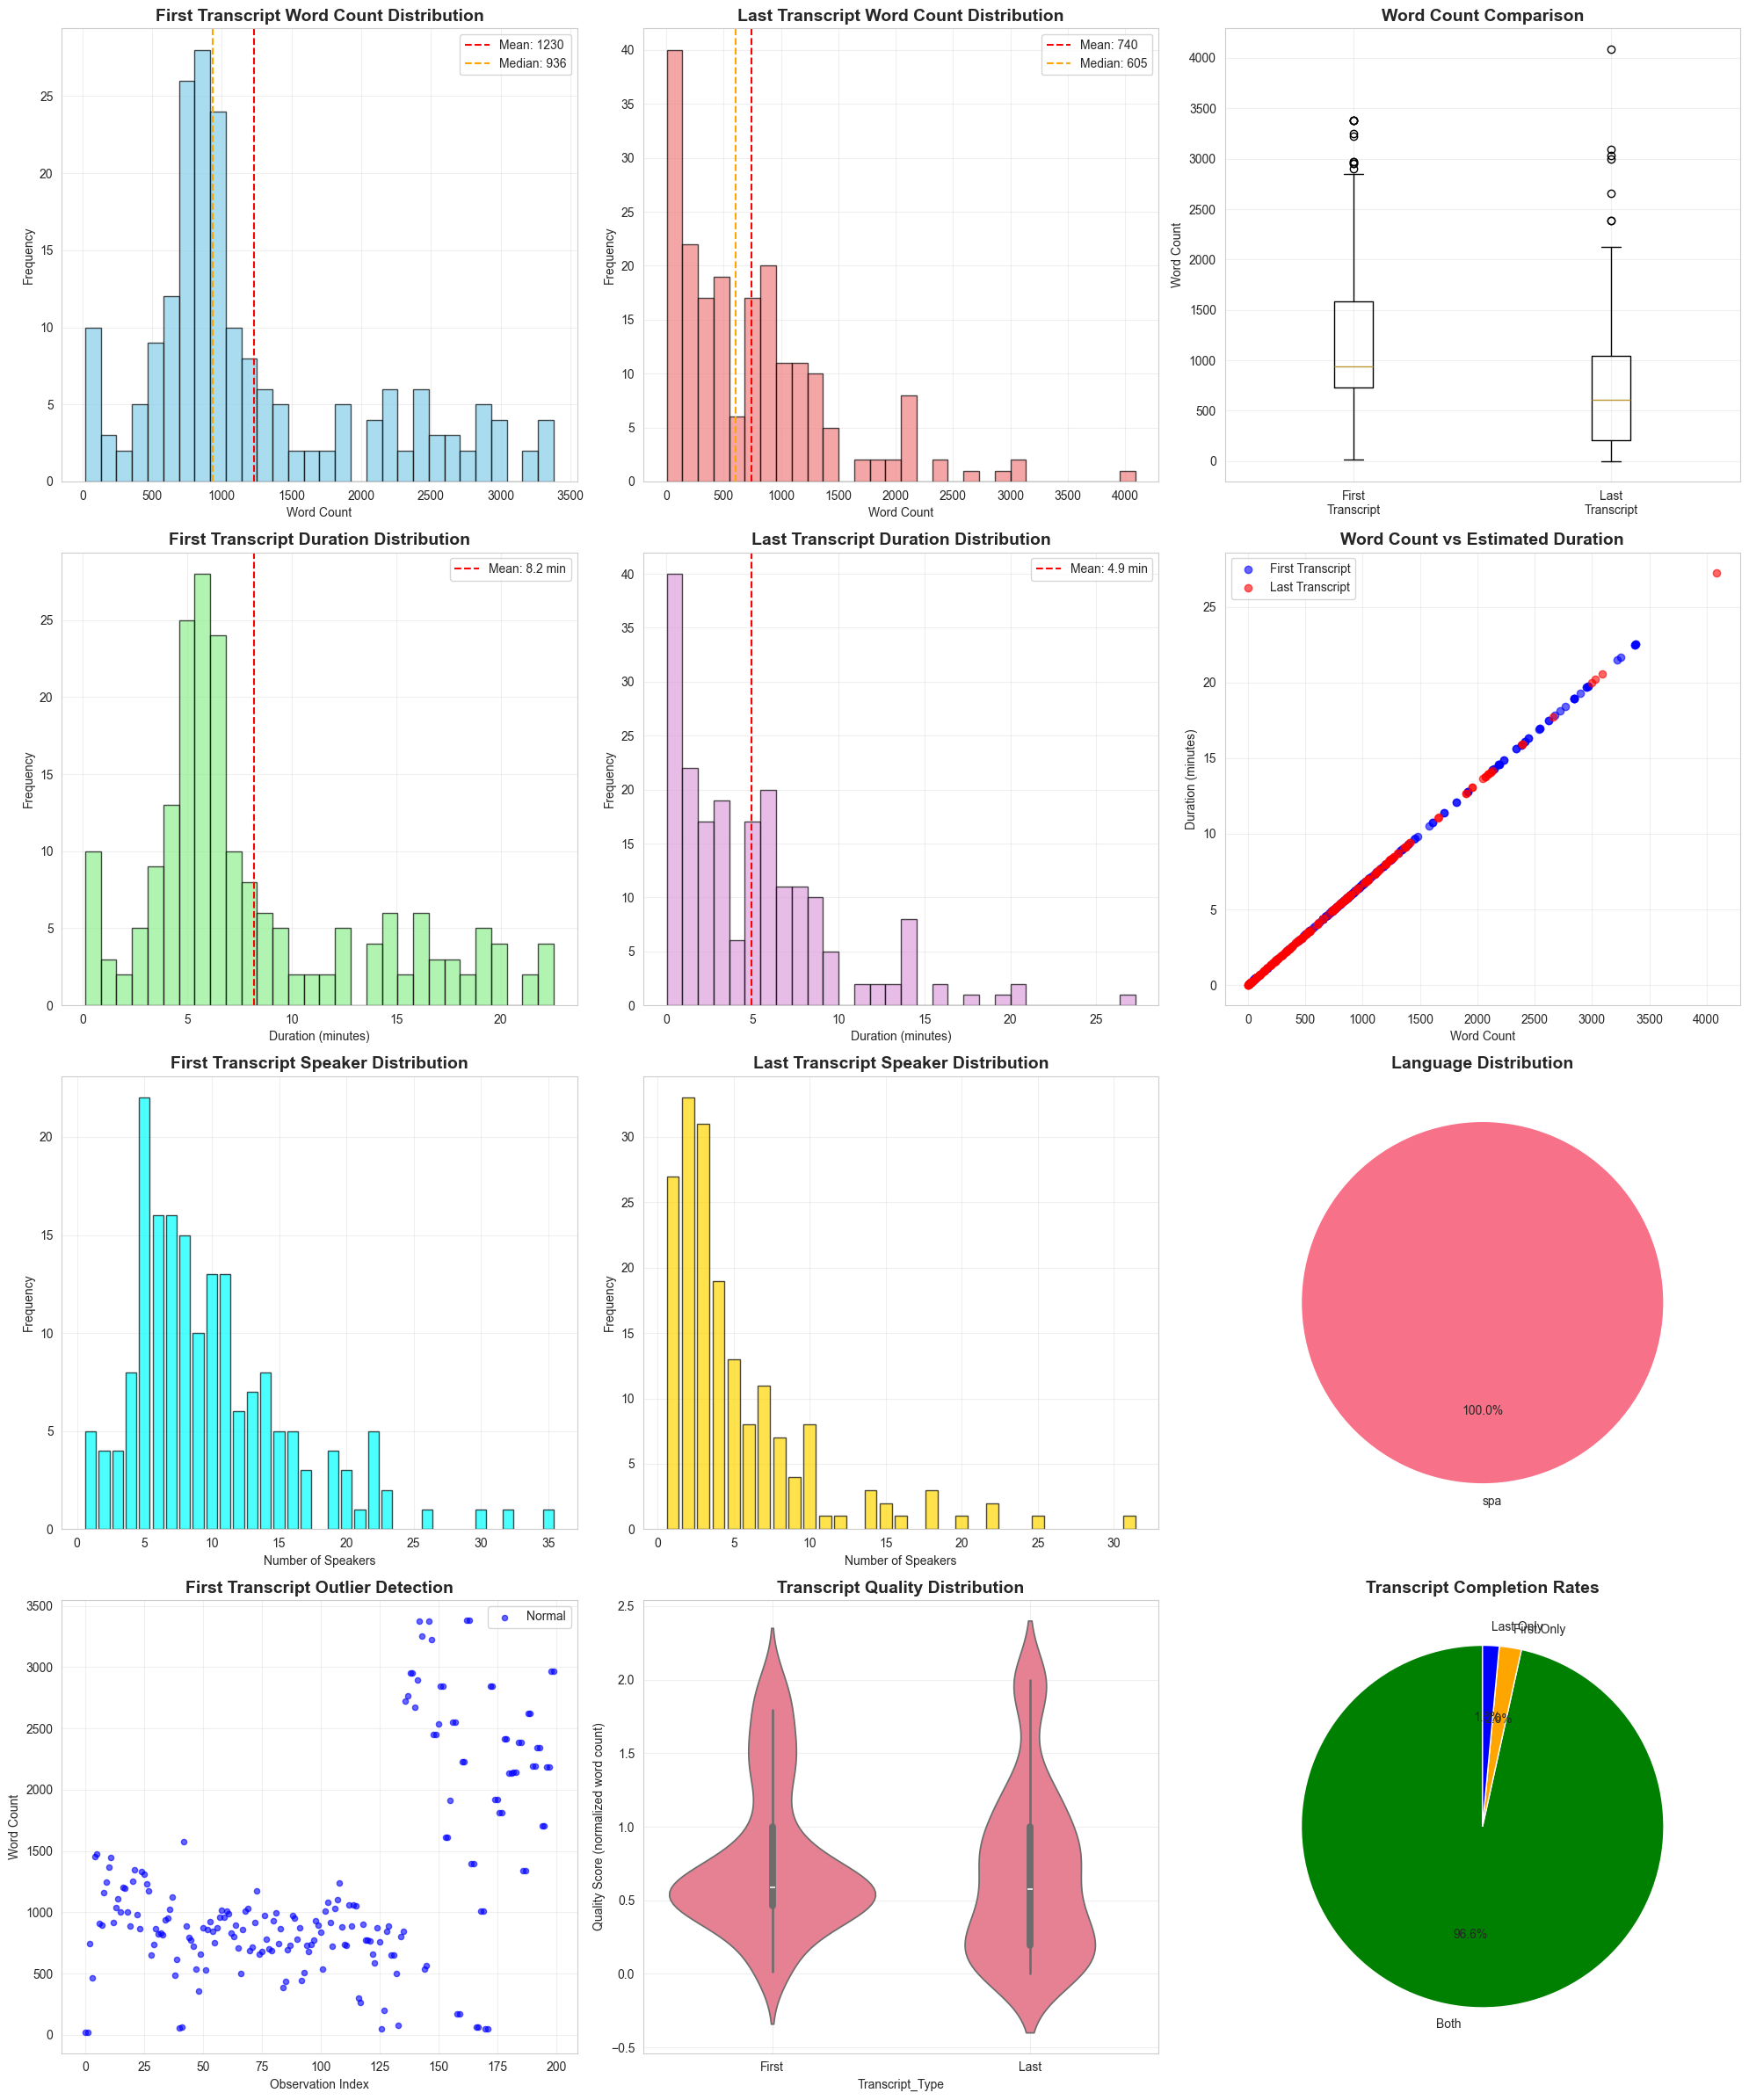

✅ Comprehensive visualization created and saved


In [15]:
# --- Create Comprehensive Visualizations -----------------------------------
print("\n" + "=" * 60)
print("📈 CREATING VISUALIZATIONS")

# Set up the plotting environment
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("whitegrid")

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# 1. Word Count Distributions
plt.subplot(4, 3, 1)
if len(first_words) > 0:
    plt.hist(first_words, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(first_words.mean(), color='red', linestyle='--', label=f'Mean: {first_words.mean():.0f}')
    plt.axvline(first_words.median(), color='orange', linestyle='--', label=f'Median: {first_words.median():.0f}')
plt.title('First Transcript Word Count Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 3, 2)
if len(last_words) > 0:
    plt.hist(last_words, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.axvline(last_words.mean(), color='red', linestyle='--', label=f'Mean: {last_words.mean():.0f}')
    plt.axvline(last_words.median(), color='orange', linestyle='--', label=f'Median: {last_words.median():.0f}')
plt.title('Last Transcript Word Count Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Box plots for comparison
plt.subplot(4, 3, 3)
word_data = []
word_labels = []
if len(first_words) > 0:
    word_data.append(first_words.values)
    word_labels.append('First\nTranscript')
if len(last_words) > 0:
    word_data.append(last_words.values)
    word_labels.append('Last\nTranscript')

if word_data:
    plt.boxplot(word_data, labels=word_labels)
    plt.title('Word Count Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Word Count')
    plt.grid(True, alpha=0.3)

# 3. Duration Distributions
plt.subplot(4, 3, 4)
if len(first_duration) > 0:
    first_duration_min = first_duration / 60
    plt.hist(first_duration_min, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(first_duration_min.mean(), color='red', linestyle='--', label=f'Mean: {first_duration_min.mean():.1f} min')
plt.title('First Transcript Duration Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 3, 5)
if len(last_duration) > 0:
    last_duration_min = last_duration / 60
    plt.hist(last_duration_min, bins=30, alpha=0.7, color='plum', edgecolor='black')
    plt.axvline(last_duration_min.mean(), color='red', linestyle='--', label=f'Mean: {last_duration_min.mean():.1f} min')
plt.title('Last Transcript Duration Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Scatter plot: Word Count vs Duration
plt.subplot(4, 3, 6)
if len(first_words) > 0 and len(first_duration) > 0:
    first_mask = (df_clean['First Audio Transcript Word Count'] > 0) & (df_clean['First Audio Transcript Estimated Duration Seconds'] > 0)
    first_scatter_words = df_clean[first_mask]['First Audio Transcript Word Count']
    first_scatter_duration = df_clean[first_mask]['First Audio Transcript Estimated Duration Seconds'] / 60
    plt.scatter(first_scatter_words, first_scatter_duration, alpha=0.6, color='blue', label='First Transcript')

if len(last_words) > 0 and len(last_duration) > 0:
    last_mask = (df_clean['Last Audio Transcript Word Count'] > 0) & (df_clean['Last Audio Transcript Estimated Duration Seconds'] > 0)
    last_scatter_words = df_clean[last_mask]['Last Audio Transcript Word Count']
    last_scatter_duration = df_clean[last_mask]['Last Audio Transcript Estimated Duration Seconds'] / 60
    plt.scatter(last_scatter_words, last_scatter_duration, alpha=0.6, color='red', label='Last Transcript')

plt.title('Word Count vs Estimated Duration', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Speaker Count Analysis
plt.subplot(4, 3, 7)
first_speakers = df_clean[df_clean['First Audio Transcript Speaker Count'] > 0]['First Audio Transcript Speaker Count']
if len(first_speakers) > 0:
    speaker_counts = first_speakers.value_counts().sort_index()
    plt.bar(speaker_counts.index, speaker_counts.values, alpha=0.7, color='cyan', edgecolor='black')
    plt.title('First Transcript Speaker Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Speakers')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.subplot(4, 3, 8)
last_speakers = df_clean[df_clean['Last Audio Transcript Speaker Count'] > 0]['Last Audio Transcript Speaker Count']
if len(last_speakers) > 0:
    speaker_counts = last_speakers.value_counts().sort_index()
    plt.bar(speaker_counts.index, speaker_counts.values, alpha=0.7, color='gold', edgecolor='black')
    plt.title('Last Transcript Speaker Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Speakers')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# 6. Language Analysis
plt.subplot(4, 3, 9)
lang_cols = ['First Audio Transcript Language Code', 'Last Audio Transcript Language Code']
all_languages = []
for col in lang_cols:
    if col in df_clean.columns:
        langs = df_clean[df_clean[col].notna() & (df_clean[col] != '')][col]
        all_languages.extend(langs.tolist())

if all_languages:
    lang_counts = pd.Series(all_languages).value_counts()
    plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Language Distribution', fontsize=14, fontweight='bold')

# 7. Outlier Visualization
plt.subplot(4, 3, 10)
if len(first_words) > 0:
    # Mark outliers in scatter plot
    first_z_scores = np.abs(stats.zscore(first_words))
    first_outlier_mask = first_z_scores > OUTLIER_THRESHOLD
    
    # Plot normal points
    normal_points = first_words[~first_outlier_mask]
    outlier_points = first_words[first_outlier_mask]
    
    plt.scatter(range(len(normal_points)), normal_points, alpha=0.6, color='blue', label='Normal', s=20)
    if len(outlier_points) > 0:
        outlier_indices = np.where(first_outlier_mask)[0]
        plt.scatter(outlier_indices, outlier_points, alpha=0.8, color='red', label='Outliers', s=50, marker='^')
    
    plt.title('First Transcript Outlier Detection', fontsize=14, fontweight='bold')
    plt.xlabel('Observation Index')
    plt.ylabel('Word Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 8. Quality Score Analysis (based on word count and duration)
plt.subplot(4, 3, 11)
# Create a quality score based on word count (normalized)
quality_scores = []
quality_labels = []

if len(first_words) > 0:
    first_quality = np.clip(first_words / first_words.quantile(0.75), 0, 2)  # Normalize to 75th percentile
    quality_scores.extend(first_quality.values)
    quality_labels.extend(['First'] * len(first_quality))

if len(last_words) > 0:
    last_quality = np.clip(last_words / last_words.quantile(0.75), 0, 2)
    quality_scores.extend(last_quality.values)
    quality_labels.extend(['Last'] * len(last_quality))

if quality_scores:
    quality_df = pd.DataFrame({'Quality_Score': quality_scores, 'Transcript_Type': quality_labels})
    sns.violinplot(data=quality_df, x='Transcript_Type', y='Quality_Score')
    plt.title('Transcript Quality Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Quality Score (normalized word count)')
    plt.grid(True, alpha=0.3)

# 9. Completion Rate by Row
plt.subplot(4, 3, 12)
completion_data = []
for idx, row in df_clean.iterrows():
    first_has = row['First Audio Transcript Word Count'] > 0
    last_has = row['Last Audio Transcript Word Count'] > 0
    
    if first_has and last_has:
        completion_data.append('Both')
    elif first_has:
        completion_data.append('First Only')
    elif last_has:
        completion_data.append('Last Only')
    else:
        completion_data.append('Neither')

completion_counts = pd.Series(completion_data).value_counts()
colors = ['green', 'orange', 'blue', 'red']
plt.pie(completion_counts.values, labels=completion_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(completion_counts)], startangle=90)
plt.title('Transcript Completion Rates', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'comprehensive_transcript_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization created and saved")



📊 DETAILED STATISTICAL ANALYSIS

📈 COMPREHENSIVE STATISTICS TABLE:
                         Metric  Count    Mean  Median  Std_Dev   Min     Max     Q1      Q3    IQR  Skewness  Kurtosis
    First Transcript Word Count    200 1230.08  936.50   817.45 20.00 3380.00 735.00 1587.50 852.50      1.00      0.13
     Last Transcript Word Count    199  739.82  605.00   698.03  3.00 4089.00 204.50 1049.00 844.50      1.54      3.17
First Transcript Duration (min)    200    8.20    6.24     5.45  0.13   22.53   4.90   10.58   5.68      1.00      0.13
 Last Transcript Duration (min)    199    4.93    4.03     4.65  0.02   27.26   1.36    6.99   5.63      1.54      3.17

💾 Statistics table saved to: /Users/mkrasnow/Desktop/montesa/new/analysis/transcript_statistics.csv

📊 CORRELATION ANALYSIS:

🔗 Correlation Matrix:
                                                   First Audio Transcript Word Count  Last Audio Transcript Word Count  First Audio Transcript Estimated Duration Seconds  Last Audio T

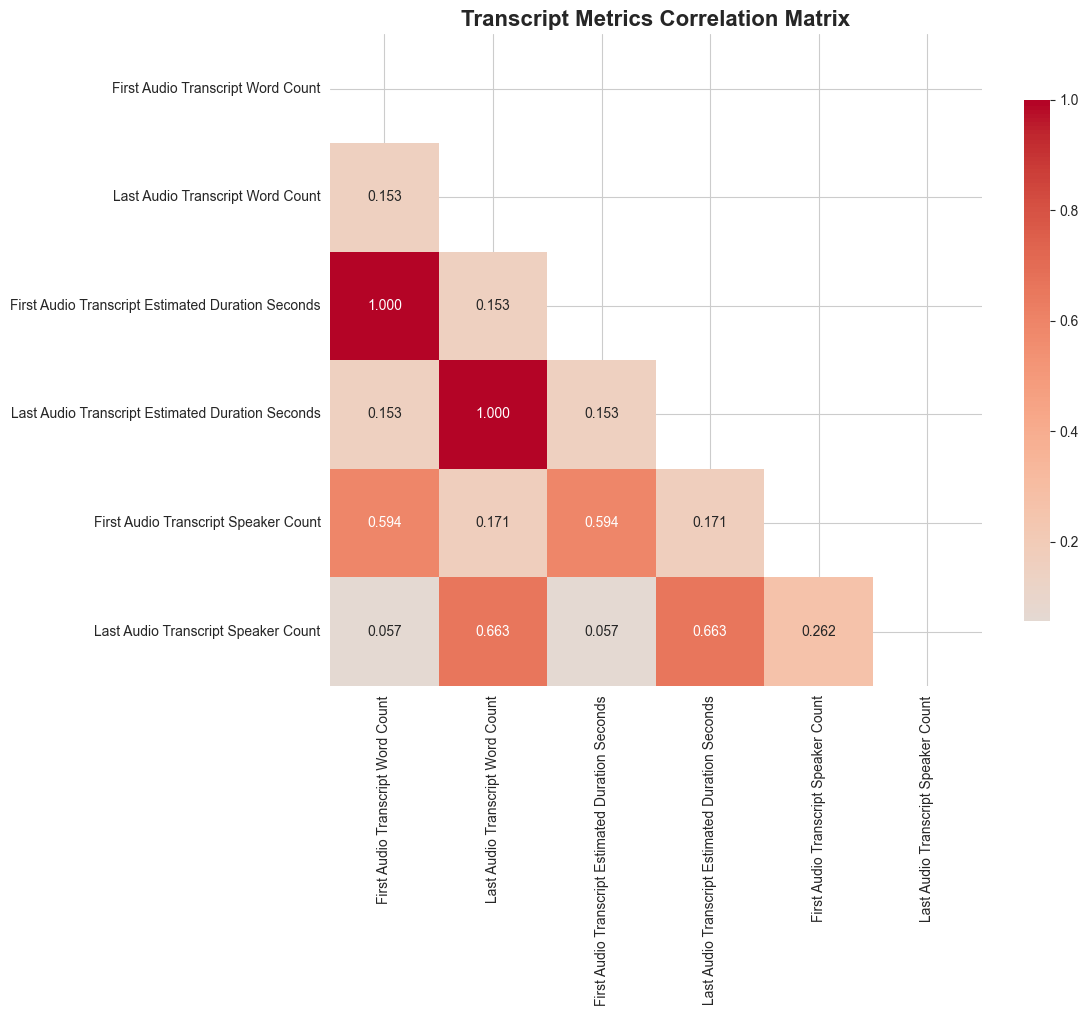

💾 Correlation matrix saved to: /Users/mkrasnow/Desktop/montesa/new/analysis/correlation_matrix.csv


In [16]:
# --- Detailed Statistical Analysis -----------------------------------------
print("\n" + "=" * 60)
print("📊 DETAILED STATISTICAL ANALYSIS")

# Create comprehensive statistics table
stats_data = []

# Word count statistics
for transcript_type, data in [('First', first_words), ('Last', last_words)]:
    if len(data) > 0:
        stats_data.append({
            'Metric': f'{transcript_type} Transcript Word Count',
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std_Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Skewness': stats.skew(data),
            'Kurtosis': stats.kurtosis(data)
        })

# Duration statistics
for transcript_type, data in [('First', first_duration_min), ('Last', last_duration_min)]:
    if len(data) > 0:
        stats_data.append({
            'Metric': f'{transcript_type} Transcript Duration (min)',
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std_Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Skewness': stats.skew(data),
            'Kurtosis': stats.kurtosis(data)
        })

stats_df = pd.DataFrame(stats_data)
if len(stats_df) > 0:
    # Round numeric columns for better display
    numeric_cols = stats_df.select_dtypes(include=[np.number]).columns
    stats_df[numeric_cols] = stats_df[numeric_cols].round(2)
    
    print("\n📈 COMPREHENSIVE STATISTICS TABLE:")
    print(stats_df.to_string(index=False))
    
    # Save statistics table
    stats_df.to_csv(ANALYSIS_DIR / 'transcript_statistics.csv', index=False)
    print(f"\n💾 Statistics table saved to: {ANALYSIS_DIR / 'transcript_statistics.csv'}")

# Correlation analysis
print("\n📊 CORRELATION ANALYSIS:")
correlation_cols = [
    'First Audio Transcript Word Count',
    'Last Audio Transcript Word Count', 
    'First Audio Transcript Estimated Duration Seconds',
    'Last Audio Transcript Estimated Duration Seconds',
    'First Audio Transcript Speaker Count',
    'Last Audio Transcript Speaker Count'
]

# Filter to existing columns
available_corr_cols = [col for col in correlation_cols if col in df_clean.columns]
if len(available_corr_cols) >= 2:
    # Use unique identifiers for correlation to avoid duplicate rows
    if 'base_id' in df_clean.columns:
        unique_df = df_clean.drop_duplicates(subset='base_id')
    else:
        unique_df = df_clean

    corr_matrix = unique_df[available_corr_cols].corr()
    print("\n🔗 Correlation Matrix:")
    print(corr_matrix.round(3).to_string())
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, mask=mask, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Transcript Metrics Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save correlation matrix
    corr_matrix.to_csv(ANALYSIS_DIR / 'correlation_matrix.csv')
    print(f"💾 Correlation matrix saved to: {ANALYSIS_DIR / 'correlation_matrix.csv'}")


In [17]:
# --- Comprehensive Outlier Analysis ----------------------------------------
print("\n" + "=" * 60)
print("🚨 COMPREHENSIVE OUTLIER ANALYSIS")

def comprehensive_outlier_analysis(data, name, df_subset=None, identifier_col='School_Clip'):
    """Perform comprehensive outlier analysis with multiple methods."""
    if len(data) < 3:
        print(f"\n⚠️ {name}: Insufficient data for outlier analysis")
        return {}
    
    print(f"\n🔍 {name.upper()} OUTLIER ANALYSIS:")
    
    results = {}
    
    # 1. Z-Score Method
    z_scores = np.abs(stats.zscore(data))
    z_outliers = z_scores > OUTLIER_THRESHOLD
    results['z_score_outliers'] = z_outliers.sum()
    
    print(f"   📊 Z-Score Method (>{OUTLIER_THRESHOLD} std devs):")
    print(f"      Outliers: {z_outliers.sum()} ({z_outliers.mean()*100:.1f}%)")
    
    if z_outliers.sum() > 0:
        outlier_values = data[z_outliers]
        print(f"      Values: {sorted(outlier_values.values)[:10]}")
        if len(outlier_values) > 10:
            print(f"      ... and {len(outlier_values) - 10} more")
    
    # 2. IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = (data < lower_bound) | (data > upper_bound)
    results['iqr_outliers'] = iqr_outliers.sum()
    
    print(f"   📊 IQR Method:")
    print(f"      Valid range: {lower_bound:.1f} - {upper_bound:.1f}")
    print(f"      Outliers: {iqr_outliers.sum()} ({iqr_outliers.mean()*100:.1f}%)")
    
    # 3. Percentile Method (extreme values)
    p1 = data.quantile(0.01)
    p99 = data.quantile(0.99)
    percentile_outliers = (data < p1) | (data > p99)
    results['percentile_outliers'] = percentile_outliers.sum()
    
    print(f"   📊 Percentile Method (outside 1st-99th percentile):")
    print(f"      Valid range: {p1:.1f} - {p99:.1f}")
    print(f"      Outliers: {percentile_outliers.sum()} ({percentile_outliers.mean()*100:.1f}%)")
    
    # 4. Very short transcripts (quality concern)
    very_short_threshold = 10
    very_short = data < very_short_threshold
    results['very_short'] = very_short.sum()
    
    print(f"   📊 Very Short Transcripts (<{very_short_threshold} words):")
    print(f"      Count: {very_short.sum()} ({very_short.mean()*100:.1f}%)")
    
    if very_short.sum() > 0 and df_subset is not None:
        short_indices = data[very_short].index
        short_identifiers = df_subset.loc[short_indices, identifier_col].tolist()
        print(f"      Identifiers: {short_identifiers[:10]}")
        if len(short_identifiers) > 10:
            print(f"      ... and {len(short_identifiers) - 10} more")
    
    # 5. Extremely long transcripts (potential errors)
    very_long_threshold = data.quantile(0.95) * 2  # 2x the 95th percentile
    very_long = data > very_long_threshold
    results['very_long'] = very_long.sum()
    
    print(f"   📊 Very Long Transcripts (>2x 95th percentile = {very_long_threshold:.1f}):")
    print(f"      Count: {very_long.sum()} ({very_long.mean()*100:.1f}%)")
    
    return results

# Analyze outliers for each transcript type
outlier_results = {}

if len(first_words) > 0:
    first_mask = df_clean['First Audio Transcript Word Count'] > 0
    first_subset = df_clean[first_mask]
    outlier_results['first'] = comprehensive_outlier_analysis(
        first_words, "First Transcript Word Counts", first_subset
    )

if len(last_words) > 0:
    last_mask = df_clean['Last Audio Transcript Word Count'] > 0
    last_subset = df_clean[last_mask]
    outlier_results['last'] = comprehensive_outlier_analysis(
        last_words, "Last Transcript Word Counts", last_subset
    )

# Create outlier summary
print(f"\n📋 OUTLIER SUMMARY:")
for transcript_type, results in outlier_results.items():
    if results:
        print(f"\n   {transcript_type.title()} Transcript:")
        for method, count in results.items():
            print(f"     {method.replace('_', ' ').title()}: {count}")

# Identify rows that should be flagged for review
problematic_rows = set()

# Add very short transcripts
if len(first_words) > 0:
    first_very_short = first_words[first_words < 10].index
    problematic_rows.update(first_very_short)

if len(last_words) > 0:
    last_very_short = last_words[last_words < 10].index
    problematic_rows.update(last_very_short)

print(f"\n🚩 ROWS FLAGGED FOR REVIEW:")
print(f"   Total flagged rows: {len(problematic_rows)}")
print(f"   Percentage of dataset: {len(problematic_rows)/len(df_clean)*100:.1f}%")

if problematic_rows and 'School_Clip' in df_clean.columns:
    flagged_identifiers = df_clean.loc[list(problematic_rows), 'School_Clip'].tolist()
    print(f"   Sample identifiers: {flagged_identifiers[:10]}")
    if len(flagged_identifiers) > 10:
        print(f"   ... and {len(flagged_identifiers) - 10} more")
    
    # Save flagged rows for review
    flagged_df = df_clean.loc[list(problematic_rows)]
    flagged_df.to_csv(ANALYSIS_DIR / 'flagged_rows_for_review.csv', index=False)
    print(f"\n💾 Flagged rows saved to: {ANALYSIS_DIR / 'flagged_rows_for_review.csv'}")



🚨 COMPREHENSIVE OUTLIER ANALYSIS

🔍 FIRST TRANSCRIPT WORD COUNTS OUTLIER ANALYSIS:
   📊 Z-Score Method (>3 std devs):
      Outliers: 0 (0.0%)
   📊 IQR Method:
      Valid range: -543.8 - 2866.2
      Outliers: 11 (5.5%)
   📊 Percentile Method (outside 1st-99th percentile):
      Valid range: 48.7 - 3377.0
      Outliers: 4 (2.0%)
   📊 Very Short Transcripts (<10 words):
      Count: 0 (0.0%)
   📊 Very Long Transcripts (>2x 95th percentile = 5801.4):
      Count: 0 (0.0%)

🔍 LAST TRANSCRIPT WORD COUNTS OUTLIER ANALYSIS:
   📊 Z-Score Method (>3 std devs):
      Outliers: 4 (2.0%)
      Values: [np.int64(2996), np.int64(3032), np.int64(3089), np.int64(4089)]
   📊 IQR Method:
      Valid range: -1062.2 - 2315.8
      Outliers: 7 (3.5%)
   📊 Percentile Method (outside 1st-99th percentile):
      Valid range: 4.0 - 3033.1
      Outliers: 4 (2.0%)
   📊 Very Short Transcripts (<10 words):
      Count: 12 (6.0%)
      Identifiers: ['237990 Clip 2', '652768 Clip 2', '233692 Clip 1', '233692 Cl

In [18]:
# --- Content and Quality Analysis ------------------------------------------
print("\n" + "=" * 60)
print("📝 CONTENT AND QUALITY ANALYSIS")

# Language analysis
print("\n🌍 LANGUAGE ANALYSIS:")
for transcript_type in ['First', 'Last']:
    lang_col = f'{transcript_type} Audio Transcript Language Code'
    prob_col = f'{transcript_type} Audio Transcript Language Probability'
    
    if lang_col in df_clean.columns:
        lang_data = df_clean[df_clean[lang_col].notna() & (df_clean[lang_col] != '')]
        
        if len(lang_data) > 0:
            print(f"\n   📊 {transcript_type} Transcript Languages:")
            lang_counts = lang_data[lang_col].value_counts()
            for lang, count in lang_counts.items():
                pct = count / len(lang_data) * 100
                print(f"      {lang}: {count} ({pct:.1f}%)")
            
            # Language confidence analysis
            if prob_col in df_clean.columns:
                prob_data = lang_data[lang_data[prob_col] > 0][prob_col]
                if len(prob_data) > 0:
                    print(f"      Language confidence: mean={prob_data.mean():.3f}, min={prob_data.min():.3f}, max={prob_data.max():.3f}")
                    low_confidence = prob_data[prob_data < 0.8]
                    if len(low_confidence) > 0:
                        print(f"      Low confidence (<0.8): {len(low_confidence)} transcripts ({len(low_confidence)/len(prob_data)*100:.1f}%)")

# Speaker analysis
print("\n👥 SPEAKER ANALYSIS:")
speaker_data = []
for transcript_type in ['First', 'Last']:
    speaker_col = f'{transcript_type} Audio Transcript Speaker Count'
    
    if speaker_col in df_clean.columns:
        speakers = df_clean[df_clean[speaker_col] > 0][speaker_col]
        
        if len(speakers) > 0:
            print(f"\n   📊 {transcript_type} Transcript Speakers:")
            speaker_counts = speakers.value_counts().sort_index()
            for num_speakers, count in speaker_counts.items():
                pct = count / len(speakers) * 100
                print(f"      {num_speakers} speaker(s): {count} ({pct:.1f}%)")
            
            speaker_data.extend([(transcript_type, s) for s in speakers])
            
            print(f"      Mean speakers: {speakers.mean():.2f}")
            print(f"      Max speakers: {speakers.max()}")

# Audio events analysis
print("\n🔊 AUDIO EVENTS ANALYSIS:")
for transcript_type in ['First', 'Last']:
    events_col = f'{transcript_type} Audio Transcript Has Audio Events'
    
    if events_col in df_clean.columns:
        events_data = df_clean[events_col]
        if len(events_data) > 0:
            has_events = events_data.sum() if events_data.dtype == bool else (events_data == True).sum()
            total = len(events_data)
            print(f"   📊 {transcript_type} Transcript Audio Events:")
            print(f"      Transcripts with audio events: {has_events} ({has_events/total*100:.1f}%)")
            print(f"      Transcripts without audio events: {total-has_events} ({(total-has_events)/total*100:.1f}%)")

# Quality score calculation
print("\n⭐ QUALITY SCORE CALCULATION:")
def calculate_quality_score(row, transcript_type):
    """Calculate a composite quality score for a transcript."""
    score = 0
    max_score = 0
    
    # Word count component (40% of score)
    word_col = f'{transcript_type} Audio Transcript Word Count'
    if word_col in row.index and not pd.isna(row[word_col]):
        words = row[word_col]
        if words > 0:
            # Score based on length: full points for 50+ words, scaled down below that
            word_score = min(words / 50, 1) * 40
            score += word_score
        max_score += 40
    
    # Language confidence component (30% of score)
    prob_col = f'{transcript_type} Audio Transcript Language Probability'
    if prob_col in row.index and not pd.isna(row[prob_col]):
        prob = row[prob_col]
        if prob > 0:
            score += prob * 30
        max_score += 30
    
    # Speaker detection component (20% of score)
    speaker_col = f'{transcript_type} Audio Transcript Speaker Count'
    if speaker_col in row.index and not pd.isna(row[speaker_col]):
        speakers = row[speaker_col]
        if speakers > 0:
            score += 20  # Full points for any speaker detection
        max_score += 20
    
    # Audio events component (10% of score)
    events_col = f'{transcript_type} Audio Transcript Has Audio Events'
    if events_col in row.index and not pd.isna(row[events_col]):
        has_events = row[events_col]
        if has_events:
            score += 10
        max_score += 10
    
    return score / max_score * 100 if max_score > 0 else 0

# Calculate quality scores
for transcript_type in ['First', 'Last']:
    quality_col = f'{transcript_type}_Quality_Score'
    df_clean[quality_col] = df_clean.apply(
        lambda row: calculate_quality_score(row, transcript_type), axis=1
    )
    
    quality_scores = df_clean[df_clean[quality_col] > 0][quality_col]
    if len(quality_scores) > 0:
        print(f"\n   📊 {transcript_type} Transcript Quality Scores:")
        print(f"      Mean: {quality_scores.mean():.1f}%")
        print(f"      Median: {quality_scores.median():.1f}%")
        print(f"      Min: {quality_scores.min():.1f}%")
        print(f"      Max: {quality_scores.max():.1f}%")
        
        # Quality categories
        excellent = (quality_scores >= 90).sum()
        good = ((quality_scores >= 70) & (quality_scores < 90)).sum()
        fair = ((quality_scores >= 50) & (quality_scores < 70)).sum()
        poor = (quality_scores < 50).sum()
        
        total = len(quality_scores)
        print(f"      Quality Distribution:")
        print(f"        Excellent (90-100%): {excellent} ({excellent/total*100:.1f}%)")
        print(f"        Good (70-89%): {good} ({good/total*100:.1f}%)")
        print(f"        Fair (50-69%): {fair} ({fair/total*100:.1f}%)")
        print(f"        Poor (<50%): {poor} ({poor/total*100:.1f}%)")



📝 CONTENT AND QUALITY ANALYSIS

🌍 LANGUAGE ANALYSIS:

   📊 First Transcript Languages:
      spa: 179 (100.0%)

   📊 Last Transcript Languages:
      spa: 177 (100.0%)

👥 SPEAKER ANALYSIS:

   📊 First Transcript Speakers:
      1 speaker(s): 5 (2.8%)
      2 speaker(s): 4 (2.2%)
      3 speaker(s): 4 (2.2%)
      4 speaker(s): 8 (4.5%)
      5 speaker(s): 22 (12.3%)
      6 speaker(s): 16 (8.9%)
      7 speaker(s): 16 (8.9%)
      8 speaker(s): 15 (8.4%)
      9 speaker(s): 10 (5.6%)
      10 speaker(s): 13 (7.3%)
      11 speaker(s): 13 (7.3%)
      12 speaker(s): 6 (3.4%)
      13 speaker(s): 7 (3.9%)
      14 speaker(s): 8 (4.5%)
      15 speaker(s): 5 (2.8%)
      16 speaker(s): 5 (2.8%)
      17 speaker(s): 3 (1.7%)
      19 speaker(s): 4 (2.2%)
      20 speaker(s): 3 (1.7%)
      21 speaker(s): 1 (0.6%)
      22 speaker(s): 5 (2.8%)
      23 speaker(s): 2 (1.1%)
      26 speaker(s): 1 (0.6%)
      30 speaker(s): 1 (0.6%)
      32 speaker(s): 1 (0.6%)
      35 speaker(s): 1 (0.6%


🔄 COMPARATIVE ANALYSIS: FIRST vs LAST TRANSCRIPTS

📊 STATISTICAL COMPARISON:

   📝 Word Count Comparison:
      First Transcripts: mean=1230.1, median=936.5, std=817.5
      Last Transcripts:  mean=739.8, median=605.0, std=698.0
      Mann-Whitney U test p-value: 0.000000
      ✅ Statistically significant difference (p < 0.05)

   ⏱️ Duration Comparison:
      First Transcripts: mean=8.20 min, median=6.24 min
      Last Transcripts:  mean=4.93 min, median=4.03 min

   👥 Speaker Count Comparison:
      First Transcripts: mean=9.92, median=8.0
      Last Transcripts:  mean=5.14, median=3.0

   ⭐ Quality Score Comparison:
      First Transcripts: mean=57.7%, median=60.0%
      Last Transcripts:  mean=53.9%, median=60.0%

🔗 PAIRED ANALYSIS (100 unique identifiers with both transcripts):
   📊 Word count correlation: 0.219
   📏 Word count differences (Last - First):
      Mean difference: -513.2 words
      Median difference: -279.0 words
      Std deviation: 951.3 words
   🎯 Length consist

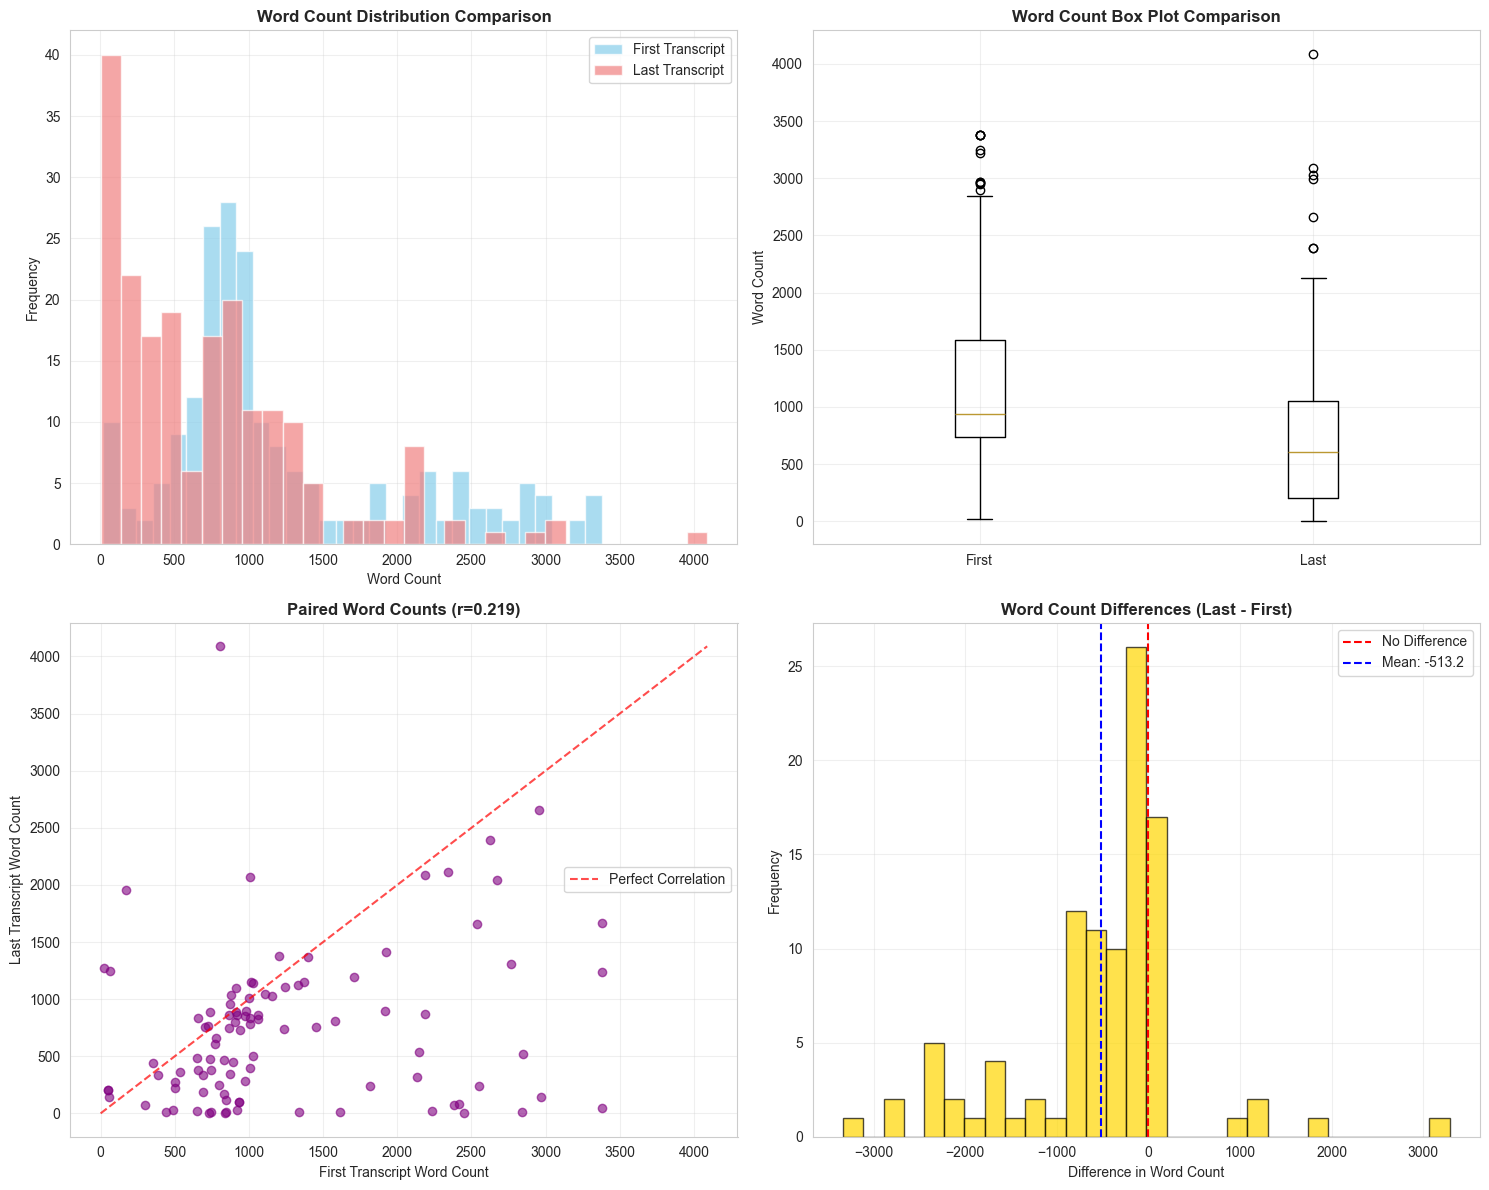


✅ Comparison visualization created and saved


In [19]:
# --- Comparative Analysis: First vs Last Transcripts -----------------------
print("\n" + "=" * 60)
print("🔄 COMPARATIVE ANALYSIS: FIRST vs LAST TRANSCRIPTS")

# Statistical comparison
print("\n📊 STATISTICAL COMPARISON:")

# Word count comparison
if len(first_words) > 0 and len(last_words) > 0:
    print("\n   📝 Word Count Comparison:")
    print(f"      First Transcripts: mean={first_words.mean():.1f}, median={first_words.median():.1f}, std={first_words.std():.1f}")
    print(f"      Last Transcripts:  mean={last_words.mean():.1f}, median={last_words.median():.1f}, std={last_words.std():.1f}")
    
    # Statistical test
    if len(first_words) > 1 and len(last_words) > 1:
        statistic, p_value = stats.mannwhitneyu(first_words, last_words, alternative='two-sided')
        print(f"      Mann-Whitney U test p-value: {p_value:.6f}")
        if p_value < 0.05:
            print(f"      ✅ Statistically significant difference (p < 0.05)")
        else:
            print(f"      ❌ No statistically significant difference (p >= 0.05)")

# Duration comparison
if len(first_duration) > 0 and len(last_duration) > 0:
    first_dur_min = first_duration / 60
    last_dur_min = last_duration / 60
    
    print("\n   ⏱️ Duration Comparison:")
    print(f"      First Transcripts: mean={first_dur_min.mean():.2f} min, median={first_dur_min.median():.2f} min")
    print(f"      Last Transcripts:  mean={last_dur_min.mean():.2f} min, median={last_dur_min.median():.2f} min")

# Speaker comparison
first_speakers = df_clean[df_clean['First Audio Transcript Speaker Count'] > 0]['First Audio Transcript Speaker Count']
last_speakers = df_clean[df_clean['Last Audio Transcript Speaker Count'] > 0]['Last Audio Transcript Speaker Count']

if len(first_speakers) > 0 and len(last_speakers) > 0:
    print("\n   👥 Speaker Count Comparison:")
    print(f"      First Transcripts: mean={first_speakers.mean():.2f}, median={first_speakers.median():.1f}")
    print(f"      Last Transcripts:  mean={last_speakers.mean():.2f}, median={last_speakers.median():.1f}")

# Quality score comparison
if 'First_Quality_Score' in df_clean.columns and 'Last_Quality_Score' in df_clean.columns:
    first_quality = df_clean[df_clean['First_Quality_Score'] > 0]['First_Quality_Score']
    last_quality = df_clean[df_clean['Last_Quality_Score'] > 0]['Last_Quality_Score']
    
    if len(first_quality) > 0 and len(last_quality) > 0:
        print("\n   ⭐ Quality Score Comparison:")
        print(f"      First Transcripts: mean={first_quality.mean():.1f}%, median={first_quality.median():.1f}%")
        print(f"      Last Transcripts:  mean={last_quality.mean():.1f}%, median={last_quality.median():.1f}%")

# Paired analysis (rows with both transcripts)
both_mask = (df_clean['First Audio Transcript Word Count'] > 0) & (df_clean['Last Audio Transcript Word Count'] > 0)
paired_data = df_clean[both_mask]

if len(paired_data) > 0:
    # For paired analysis, use one row per identifier to avoid duplicates
    paired_unique = paired_data.drop_duplicates(subset='base_id')
    print(f"\n🔗 PAIRED ANALYSIS ({len(paired_unique)} unique identifiers with both transcripts):")
    
    # Word count correlation
    first_paired_words = paired_unique['First Audio Transcript Word Count']
    last_paired_words = paired_unique['Last Audio Transcript Word Count']
    
    correlation = first_paired_words.corr(last_paired_words)
    print(f"   📊 Word count correlation: {correlation:.3f}")
    
    # Difference analysis
    word_diff = last_paired_words - first_paired_words
    print(f"   📏 Word count differences (Last - First):")
    print(f"      Mean difference: {word_diff.mean():.1f} words")
    print(f"      Median difference: {word_diff.median():.1f} words")
    print(f"      Std deviation: {word_diff.std():.1f} words")
    
    # Consistency analysis
    similar_length = np.abs(word_diff) <= 10  # Within 10 words
    print(f"   🎯 Length consistency (within 10 words): {similar_length.sum()} ({similar_length.mean()*100:.1f}%)")
    
    # Direction analysis
    last_longer = word_diff > 0
    first_longer = word_diff < 0
    same_length = word_diff == 0
    
    print(f"   📈 Length patterns:")
    print(f"      Last transcript longer: {last_longer.sum()} ({last_longer.mean()*100:.1f}%)")
    print(f"      First transcript longer: {first_longer.sum()} ({first_longer.mean()*100:.1f}%)")
    print(f"      Same length: {same_length.sum()} ({same_length.mean()*100:.1f}%)")

# Create comparison visualization
if len(first_words) > 0 or len(last_words) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Word count comparison
    axes[0,0].hist(first_words, alpha=0.7, label='First Transcript', bins=30, color='skyblue')
    axes[0,0].hist(last_words, alpha=0.7, label='Last Transcript', bins=30, color='lightcoral')
    axes[0,0].set_title('Word Count Distribution Comparison', fontweight='bold')
    axes[0,0].set_xlabel('Word Count')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Box plot comparison
    comparison_data = []
    comparison_labels = []
    if len(first_words) > 0:
        comparison_data.append(first_words.values)
        comparison_labels.append('First')
    if len(last_words) > 0:
        comparison_data.append(last_words.values)
        comparison_labels.append('Last')
    
    if comparison_data:
        axes[0,1].boxplot(comparison_data, labels=comparison_labels)
        axes[0,1].set_title('Word Count Box Plot Comparison', fontweight='bold')
        axes[0,1].set_ylabel('Word Count')
        axes[0,1].grid(True, alpha=0.3)
    
    # Scatter plot for paired data
    if len(paired_unique) > 0:
        axes[1,0].scatter(paired_unique['First Audio Transcript Word Count'], 
                         paired_unique['Last Audio Transcript Word Count'],
                         alpha=0.6, color='purple')
        
        # Add diagonal line for perfect correlation
        max_val = max(paired_unique['First Audio Transcript Word Count'].max(),
                     paired_unique['Last Audio Transcript Word Count'].max())
        axes[1,0].plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Perfect Correlation')
        
        axes[1,0].set_title(f'Paired Word Counts (r={correlation:.3f})', fontweight='bold')
        axes[1,0].set_xlabel('First Transcript Word Count')
        axes[1,0].set_ylabel('Last Transcript Word Count')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Difference histogram
    if len(paired_unique) > 0:
        axes[1,1].hist(word_diff, bins=30, alpha=0.7, color='gold', edgecolor='black')
        axes[1,1].axvline(0, color='red', linestyle='--', label='No Difference')
        axes[1,1].axvline(word_diff.mean(), color='blue', linestyle='--', label=f'Mean: {word_diff.mean():.1f}')
        axes[1,1].set_title('Word Count Differences (Last - First)', fontweight='bold')
        axes[1,1].set_xlabel('Difference in Word Count')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'first_vs_last_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Comparison visualization created and saved")


In [20]:
# --- Final Summary and Recommendations -------------------------------------
print("\n" + "=" * 60)
print("📋 FINAL SUMMARY AND RECOMMENDATIONS")
print("=" * 60)

# Dataset summary
print(f"\n📊 DATASET SUMMARY:")
print(f"   📁 Original rows: {initial_row_count:,}")
print(f"   📁 Final cleaned rows: {len(df_clean):,}")
print(f"   🗑️ Removed rows: {removed_count:,} ({removed_count/initial_row_count*100:.1f}%)")
print(f"   📈 Data retention rate: {len(df_clean)/initial_row_count*100:.1f}%")

# Transcript availability summary
first_count = (df_clean['First Audio Transcript Word Count'] > 0).sum()
last_count = (df_clean['Last Audio Transcript Word Count'] > 0).sum()
both_count = ((df_clean['First Audio Transcript Word Count'] > 0) & 
              (df_clean['Last Audio Transcript Word Count'] > 0)).sum()

print(f"\n🗣️ TRANSCRIPT AVAILABILITY:")
print(f"   📝 First transcripts available: {first_count:,} ({first_count/len(df_clean)*100:.1f}%)")
print(f"   📝 Last transcripts available: {last_count:,} ({last_count/len(df_clean)*100:.1f}%)")
print(f"   📝 Both transcripts available: {both_count:,} ({both_count/len(df_clean)*100:.1f}%)")
print(f"   📝 Total transcript instances: {first_count + last_count:,}")
print(f"💾 Final analysis summary saved to: {summary_file}")
print(f"✅ ANALYSIS COMPLETE!")
print(f"   🎉 Data cleaning and EDA successfully completed")
print(f"   📊 {len(df_clean):,} clean rows ready for further analysis")
print(f"   📈 Comprehensive visualizations and statistics generated")
print(f"   🔍 Quality assessment and outlier detection completed")
# Final data validation check
print(f"🔬 FINAL DATA VALIDATION:")
print(f"   📊 Total cleaned rows: {len(df_clean):,}")
print(f"   📝 Rows with first transcripts: {(df_clean['First Audio Transcript Word Count'] > 0).sum():,}")
print(f"   📝 Rows with last transcripts: {(df_clean['Last Audio Transcript Word Count'] > 0).sum():,}")
print(f"   ⚠️ Rows flagged for review: {len(problematic_rows) if 'problematic_rows' in locals() else 0:,}")
print(f"   ✅ Data integrity: {'PASSED' if len(df_clean) > 0 else 'FAILED'}")
print(f"=" * 60)
print(f"🎊 SUCCESS! Your Peru transcript dataset is now cleaned and analyzed!")
print(f"📁 Check the '{ANALYSIS_DIR.name}' folder for all outputs and visualizations.")
print(f"=" * 60)



📋 FINAL SUMMARY AND RECOMMENDATIONS

📊 DATASET SUMMARY:
   📁 Original rows: 208
   📁 Final cleaned rows: 203
   🗑️ Removed rows: 5 (2.4%)
   📈 Data retention rate: 97.6%

🗣️ TRANSCRIPT AVAILABILITY:
   📝 First transcripts available: 200 (98.5%)
   📝 Last transcripts available: 199 (98.0%)
   📝 Both transcripts available: 196 (96.6%)
   📝 Total transcript instances: 399
💾 Final analysis summary saved to: /Users/mkrasnow/Desktop/montesa/new/analysis/cleaning_summary.json
✅ ANALYSIS COMPLETE!
   🎉 Data cleaning and EDA successfully completed
   📊 203 clean rows ready for further analysis
   📈 Comprehensive visualizations and statistics generated
   🔍 Quality assessment and outlier detection completed
🔬 FINAL DATA VALIDATION:
   📊 Total cleaned rows: 203
   📝 Rows with first transcripts: 200
   📝 Rows with last transcripts: 199
   ⚠️ Rows flagged for review: 12
   ✅ Data integrity: PASSED
🎊 SUCCESS! Your Peru transcript dataset is now cleaned and analyzed!
📁 Check the 'analysis' folder fo